# Imports

In [1]:
import itertools
import os

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Importar o otimizador Adam


2025-10-06 18:40:19.372194: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 18:40:19.726340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-06 18:40:21.626563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Utils

## Data Utils

In [2]:
def load_data(base_path, weeks, file_type='input'):
    all_dfs = []
    for week in weeks:
        file_name = f"{file_type}_2023_w{str(week).zfill(2)}.csv"
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['week'] = week
            all_dfs.append(df)
    if not all_dfs: return pd.DataFrame()
    return pd.concat(all_dfs, ignore_index=True)

## Feature Engineering Utils

In [3]:
def convert_height_to_inches(height_str):
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except: return np.nan

def calculate_age(birth_date_str, current_date=datetime(2024, 1, 1)):
    try:
        birth_date = datetime.strptime(str(birth_date_str), '%Y-%m-%d')
        return (current_date - birth_date).days / 365.25
    except: return np.nan

def feature_engineering(df, output_df=None, is_test=False):
    """
    Uma função de pré-processamento revisada que inclui a padronização do campo
    e tratamento robusto de ângulos.
    """
    print("Iniciando pré-processamento robusto...")

    # --- 1. Padronização do Campo de Jogo ---
    # Todas as jogadas serão padronizadas para se moverem da esquerda para a direita.
    
    # Identifica as jogadas que vão para a esquerda
    left_direction_plays = df['play_direction'] == 'left'
    
    # Inverte as coordenadas X para essas jogadas
    df.loc[left_direction_plays, 'x'] = 120.0 - df.loc[left_direction_plays, 'x']
    df.loc[left_direction_plays, 'ball_land_x'] = 120.0 - df.loc[left_direction_plays, 'ball_land_x']
    
    # Inverte as coordenadas Y
    df.loc[left_direction_plays, 'y'] = 53.3 - df.loc[left_direction_plays, 'y']
    df.loc[left_direction_plays, 'ball_land_y'] = 53.3 - df.loc[left_direction_plays, 'ball_land_y']
    
    # Inverte os ângulos de direção e orientação
    df.loc[left_direction_plays, 'dir'] = (360.0 - df.loc[left_direction_plays, 'dir']) % 360
    df.loc[left_direction_plays, 'o'] = (360.0 - df.loc[left_direction_plays, 'o']) % 360

    # Se estivermos processando dados de treino/validação, inverter o output também!
    if not is_test and output_df is not None:
        # Precisamos mapear quais jogadas no output_df precisam ser invertidas
        plays_to_flip = df[left_direction_plays][['game_id', 'play_id']].drop_duplicates()
        
        # Fazendo merge para encontrar as linhas correspondentes no output_df
        output_merged = output_df.merge(plays_to_flip, on=['game_id', 'play_id'], how='inner')
        indices_to_flip = output_merged.index
        
        output_df.loc[indices_to_flip, 'x'] = 120.0 - output_df.loc[indices_to_flip, 'x']
        output_df.loc[indices_to_flip, 'y'] = 53.3 - output_df.loc[indices_to_flip, 'y']


    # --- 2. Engenharia de Atributos (com tratamento de ângulos) ---
    # Limpeza de altura e cálculo de idade (como antes)
    df['player_height_inches'] = df['player_height'].apply(convert_height_to_inches)
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df.fillna(0, inplace=True) # Preenchimento simples de NaNs

    # Atributos relativos ao ponto de pouso da bola (agora com coordenadas padronizadas)
    df['delta_x_to_land'] = df['ball_land_x'] - df['x']
    df['delta_y_to_land'] = df['ball_land_y'] - df['y']
    df['dist_to_land_spot'] = np.sqrt(df['delta_x_to_land']**2 + df['delta_y_to_land']**2)

    # Tratamento robusto de ângulos cíclicos
    for angle_col in ['dir', 'o']:
        rad_col = np.deg2rad(df[angle_col])
        df[f'{angle_col}_sin'] = np.sin(rad_col)
        df[f'{angle_col}_cos'] = np.cos(rad_col)

    # Componentes de velocidade
    df['vx'] = df['s'] * df['dir_cos']
    df['vy'] = df['s'] * df['dir_sin']

    # --- 3. (Opcional, mas recomendado) Transformar o alvo para Deslocamento ---
    if not is_test and output_df is not None:
        # Agrupa por jogador/jogada para calcular o delta
        output_df = output_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
        
        # Pega a última posição conhecida do input para cada jogada/jogador
        last_input_pos = df.loc[df.groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].idxmax()]
        last_input_pos = last_input_pos[['game_id', 'play_id', 'nfl_id', 'x', 'y']].rename(columns={'x': 'last_x', 'y': 'last_y'})
        
        # Junta com o output
        output_df = output_df.merge(last_input_pos, on=['game_id', 'play_id', 'nfl_id'], how='left')
        
        # Calcula o deslocamento frame a frame
        output_df[['prev_x', 'prev_y']] = output_df.groupby(['game_id', 'play_id', 'nfl_id'])[['x', 'y']].shift(1)
        
        # O primeiro frame de output usa a última posição do input como referência
        output_df['prev_x'].fillna(output_df['last_x'], inplace=True)
        output_df['prev_y'].fillna(output_df['last_y'], inplace=True)
        
        # Cria as colunas de alvo (delta_x, delta_y)
        output_df['x'] = output_df['x'] - output_df['prev_x']
        output_df['y'] = output_df['y'] - output_df['prev_y']
        
        # Limpa colunas auxiliares
        output_df.drop(columns=['last_x', 'last_y', 'prev_x', 'prev_y'], inplace=True)


    print("Pré-processamento robusto concluído.")
    if is_test:
        return df
    else:
        return df, output_df

## Preprocessing Utils

In [4]:
def create_sequences(input_df, output_df, features_to_use, max_input_len, max_output_len, is_test=False):
    unique_plays = input_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates()
    
    encoder_input_data = []
    decoder_output_data = [] # Apenas para treino/validação
    play_identifiers = [] # Para mapear previsões de volta

    for _, row in unique_plays.iterrows():
        game_id, play_id, nfl_id = row['game_id'], row['play_id'], row['nfl_id']
        
        input_seq = input_df[(input_df['game_id'] == game_id) & (input_df['play_id'] == play_id) & (input_df['nfl_id'] == nfl_id)]
        input_features = input_seq[features_to_use].values
        
        padded_input = np.zeros((max_input_len, len(features_to_use)))
        seq_len = min(len(input_features), max_input_len)
        padded_input[-seq_len:] = input_features[-seq_len:]
        encoder_input_data.append(padded_input)
        play_identifiers.append((game_id, play_id, nfl_id, input_seq['num_frames_output'].iloc[0]))
        
        if not is_test:
            output_seq = output_df[(output_df['game_id'] == game_id) & (output_df['play_id'] == play_id) & (output_df['nfl_id'] == nfl_id)]
            output_coords = output_seq[['x', 'y']].values
            
            padded_output = np.zeros((max_output_len, 2))
            seq_len_out = min(len(output_coords), max_output_len)
            if seq_len_out > 0:
                padded_output[:seq_len_out] = output_coords[:seq_len_out]
            decoder_output_data.append(padded_output)

    if is_test:
        return np.array(encoder_input_data), play_identifiers
    else:
        return np.array(encoder_input_data), np.array(decoder_output_data)

## Model Utils

In [5]:
## Model Utils

def masked_mse_loss(y_true, y_pred):
    """
    Calcula o Mean Squared Error apenas nos timesteps que não são padding.
    Versão robusta para evitar divisão por zero.
    """
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=-1), 0)
    squared_error = tf.square(y_pred - y_true)
    masked_squared_error = tf.boolean_mask(squared_error, mask)
    
    # Adiciona um pequeno epsilon para evitar NaN se o tensor estiver vazio
    return tf.reduce_mean(masked_squared_error) + 1e-7

def masked_rmse_metric(y_true, y_pred):
    """
    Métrica Root Mean Squared Error que ignora o padding.
    """
    return tf.sqrt(masked_mse_loss(y_true, y_pred))

In [6]:
def build_seq2seq_model(input_shape, output_seq_len, latent_dim=128, dropout_rate=0.2):
    # Encoder com 2 camadas LSTM empilhadas
    encoder_inputs = Input(shape=input_shape, name='encoder_input')
    encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm1')
    encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
    encoder_lstm2 = LSTM(latent_dim, return_state=True, name='encoder_lstm2')
    encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
    encoder_states = [state_h2, state_c2]

    # Decoder com 2 camadas LSTM empilhadas + Dropout
    decoder_inputs = Input(shape=(None, 2), name='decoder_input_for_training')
    decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm1')
    decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
    decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm2')
    decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)
    decoder_outputs2 = Dropout(dropout_rate)(decoder_outputs2)
    decoder_dense = TimeDistributed(Dense(128, activation='relu'), name='time_distributed_dense1')
    decoder_outputs3 = decoder_dense(decoder_outputs2)
    decoder_final = TimeDistributed(Dense(2, name='output_coords'), name='time_distributed_dense2')(decoder_outputs3)

    model = Model([encoder_inputs, decoder_inputs], decoder_final)

    # --- Modelos de Inferência ---
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_single_step_input = Input(shape=(1, 2))
    dec_out1, _, _ = decoder_lstm1(decoder_single_step_input, initial_state=decoder_states_inputs)
    dec_out2, state_h_inf, state_c_inf = decoder_lstm2(dec_out1)
    dec_out2 = Dropout(dropout_rate)(dec_out2)
    dec_out3 = decoder_dense(dec_out2)
    dec_final = TimeDistributed(Dense(2, name='output_coords'), name='time_distributed_dense2')(dec_out3)
    decoder_states_inf = [state_h_inf, state_c_inf]

    decoder_model = Model(
        [decoder_single_step_input] + decoder_states_inputs,
        [dec_final] + decoder_states_inf
    )

    return model, encoder_model, decoder_model

In [ ]:
def run_training_pipeline(config):
    """Função principal que encapsula todo o processo de treinamento."""
    
    PROCESSED_DATA_PATH = 'processed_training_data.npz'

    # --- LÓGICA DE CARREGAMENTO ---
    # Verifica se os dados processados já existem
    if not os.path.exists(PROCESSED_DATA_PATH):
        print("Dados pré-processados não encontrados. Executando o pipeline completo...")
        # --- Carregamento de TODOS os dados de treino ---
        print("Carregando dados de treinamento (Semanas 1-18)...")
        input_df = load_data(config['BASE_PATH'], range(1, 19), 'input')
        output_df = load_data(config['BASE_PATH'], range(1, 19), 'output')
        
        # --- Engenharia de Atributos ---
        print("Executando engenharia de atributos...")
        input_df, output_df = feature_engineering(input_df, output_df)

        # --- Definição do Pré-processador ---
        numeric_features = [
            'x', 'y', 's', 'a', 
            'player_height_inches', 'player_age', 
            'dist_to_land_spot', 'delta_x_to_land', 'delta_y_to_land', 
            'vx', 'vy',
            'dir_sin', 'dir_cos', 'o_sin', 'o_cos'
        ]
        categorical_features = [
            'player_position', 'player_side', 'player_role'
        ]
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
            ], remainder='drop'
        )
        
        # --- Divisão Treino/Validação por semana ---
        train_df = input_df[input_df['week'].isin(config['TRAIN_WEEKS'])]
        val_df = input_df[input_df['week'].isin(config['VALIDATION_WEEKS'])]
        
        # AJUSTAR ('fit') o preprocessor APENAS nos dados de treino
        print("Ajustando o pré-processador nos dados de treino...")
        preprocessor.fit(train_df[numeric_features + categorical_features])
        
        # Salvar o preprocessor para uso na inferência
        joblib.dump(preprocessor, 'preprocessor.joblib')
        
        # Aplicar a transformação
        processed_train_data = preprocessor.transform(train_df[numeric_features + categorical_features])
        processed_val_data = preprocessor.transform(val_df[numeric_features + categorical_features])
        
        feature_names = preprocessor.get_feature_names_out()
        
        processed_train_df = pd.DataFrame(processed_train_data, columns=feature_names, index=train_df.index)
        processed_val_df = pd.DataFrame(processed_val_data, columns=feature_names, index=val_df.index)
        
        id_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
        final_train_df = pd.concat([train_df[id_cols], processed_train_df], axis=1)
        final_val_df = pd.concat([val_df[id_cols], processed_val_df], axis=1)

        # --- Criação de Sequências ---
        print("Criando sequências de treino e validação...")
        X_enc_train, y_dec_train = create_sequences(final_train_df, output_df, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'])
        X_enc_val, y_dec_val = create_sequences(final_val_df, output_df, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'])

        print(f"Salvando dados pré-processados em '{PROCESSED_DATA_PATH}'...")
        np.savez_compressed(
            PROCESSED_DATA_PATH,
            X_enc_train=X_enc_train,
            y_dec_train=y_dec_train,
            X_enc_val=X_enc_val,
            y_dec_val=y_dec_val
        )
        print("Dados salvos com sucesso para uso futuro.")
        
    else:
        print(f"Carregando dados pré-processados de '{PROCESSED_DATA_PATH}'...")
        processed_data = np.load(PROCESSED_DATA_PATH)
        X_enc_train = processed_data['X_enc_train']
        y_dec_train = processed_data['y_dec_train']
        X_enc_val = processed_data['X_enc_val']
        y_dec_val = processed_data['y_dec_val']
        print("Dados carregados com sucesso.") 
    
    # Input do decoder para teacher forcing
    dec_input_train = np.zeros_like(y_dec_train); dec_input_train[:, 1:, :] = y_dec_train[:, :-1, :]
    dec_input_val = np.zeros_like(y_dec_val); dec_input_val[:, 1:, :] = y_dec_val[:, :-1, :]

    # --- Construção e Treinamento do Modelo ---
    input_shape = X_enc_train.shape[1:]
    model, encoder_model, decoder_model = build_seq2seq_model(input_shape, config['MAX_OUTPUT_LEN'], config['LATENT_DIM'])

    # --- MUDANÇAS AQUI ---
    # 1. Crie um otimizador Adam com gradient clipping
    optimizer = Adam(learning_rate=0.0005, clipnorm=1.0) # Taxa de aprendizado menor e clipping

    # 2. Compile o modelo com o novo otimizador e as funções de perda robustas
    model.compile(optimizer=optimizer, 
                # loss=masked_mse_loss, 
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    model.summary()

    callbacks = [EarlyStopping(monitor='val_loss', patience=config['EARLY_STOPPING'], restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)]
    
    print("\nIniciando o treinamento...")
    history = model.fit(
        [X_enc_train, dec_input_train], y_dec_train,
        batch_size=config['BATCH_SIZE'],
        epochs=config['EPOCHS'],
        validation_data=([X_enc_val, dec_input_val], y_dec_val),
        callbacks=callbacks
    )
    
    # Salvar os modelos de inferência
    encoder_model.save('encoder_model.h5')
    decoder_model.save('decoder_model.h5')
    
    print("Treinamento concluído e modelos salvos.")
    return model, history

## Submission Utils

In [8]:
## Submission Utils

def reconstruct_and_format_submission(raw_predictions, play_identifiers, original_test_df):
    """
    Converte as previsões de deslocamento (deltas) do modelo em coordenadas
    absolutas (x, y), re-inverte o campo se necessário, e formata o arquivo final.
    """
    print("Iniciando a reconstrução das trajetórias e formatação da submissão...")
    
    # Passo 1: Obter a última posição conhecida de cada jogador do DF original
    last_positions = original_test_df.loc[
        original_test_df.groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].idxmax()
    ]
    
    submission_rows = []

    # Passo 2: Iterar sobre cada previsão para reconstruir a trajetória
    for i, play_info in enumerate(play_identifiers):
        game_id, play_id, nfl_id, num_frames_to_predict = play_info
        predicted_deltas = raw_predictions[i]

        # Pega a última posição real para ser nosso ponto de partida
        try:
            start_pos_row = last_positions[
                (last_positions['game_id'] == game_id) &
                (last_positions['play_id'] == play_id) &
                (last_positions['nfl_id'] == nfl_id)
            ]
            
            # Posição inicial para a reconstrução (do DF original, antes da padronização)
            current_pos = start_pos_row[['x', 'y']].values[0].copy()
            # Direção original da jogada
            original_direction = start_pos_row['play_direction'].iloc[0]

        except IndexError:
            # Fallback improvável
            current_pos = np.array([0.0, 0.0])
            original_direction = 'right'

        # Passo 3: Loop de soma cumulativa para obter coordenadas absolutas
        for frame_idx in range(num_frames_to_predict):
            delta = predicted_deltas[frame_idx]
            current_pos += delta
            absolute_pos = current_pos.copy()

            # Passo 4: Re-inverter as coordenadas se a jogada original era para a esquerda
            if original_direction == 'left':
                absolute_pos[0] = 120.0 - absolute_pos[0]
                absolute_pos[1] = 53.3 - absolute_pos[1]

            # Formata a linha para o arquivo de submissão
            frame_id = frame_idx + 1
            row_id = f"{game_id}_{play_id}_{nfl_id}_{frame_id}"
            submission_rows.append({'id': row_id, 'x': absolute_pos[0], 'y': absolute_pos[1]})

    # Passo 5: Criar e salvar o DataFrame final
    submission_df = pd.DataFrame(submission_rows)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"\nArquivo 'submission.csv' gerado com sucesso com {len(submission_df)} linhas.")
    return submission_df


def predict_and_format_submission(config):
    """Carrega os dados de teste, aplica o pipeline e gera a submissão."""
    print("\nIniciando pipeline de inferência...")

    # --- Carregar Dados de Teste e Modelos ---
    # Carrega os dados de teste originais e guarda uma cópia limpa
    original_test_df = pd.read_csv(os.path.join(config['BASE_PATH'], 'test_input.csv'))
    test_input_df = original_test_df.copy() # Trabalha com uma cópia

    encoder_model = tf.keras.models.load_model('encoder_model.h5')
    decoder_model = tf.keras.models.load_model('decoder_model.h5')
    preprocessor = joblib.load('preprocessor.joblib')

    # --- Pré-processamento e Engenharia de Atributos (no modo de teste) ---
    # A função feature_engineering agora só retorna um DataFrame
    test_input_df_processed = feature_engineering(test_input_df, is_test=True)
    
    numeric_features = ['x', 'y', 's', 'a', 'player_height_inches', 'player_age', 'dist_to_land_spot', 'delta_x_to_land', 'delta_y_to_land', 'vx', 'vy', 'dir_sin', 'dir_cos', 'o_sin', 'o_cos']
    categorical_features = ['player_position', 'player_side', 'player_role']
    # Removido 'play_direction' pois foi usado para padronizar o campo
    
    # ATENÇÃO: As features aqui devem ser exatamente as mesmas usadas no preprocessor do treino
    # Se você adicionou/removeu features, ajuste esta lista.
    feature_names = preprocessor.get_feature_names_out()
    
    processed_test_data = preprocessor.transform(test_input_df_processed)
    processed_test_df = pd.DataFrame(processed_test_data, columns=feature_names, index=test_input_df_processed.index)
    
    id_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
    final_test_df = pd.concat([test_input_df_processed[id_cols], processed_test_df], axis=1)

    # --- Criar Sequências de Teste ---
    X_enc_test, play_identifiers = create_sequences(final_test_df, None, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'], is_test=True)
    
    # --- Gerar Previsões de DELTAS (Loop de Inferência) ---
    raw_predictions = []
    total_sequences = len(X_enc_test)
    for i in range(total_sequences):
        if (i + 1) % 100 == 0:
            print(f"Prevendo sequência {i+1}/{total_sequences}...")
            
        input_seq = X_enc_test[i:i+1]
        states_value = encoder_model.predict(input_seq, verbose=0)
        
        target_seq = np.zeros((1, 1, 2)) # Começa com delta (0,0)
        
        num_frames_to_predict = play_identifiers[i][3]
        output_sequence = []

        for _ in range(num_frames_to_predict):
            # O decoder agora é mais complexo, precisamos pegar os estados corretos
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
            
            output_sequence.append(output_tokens[0, 0, :])
            target_seq = output_tokens
            states_value = [h, c]
        
        raw_predictions.append(output_sequence)
        
    # --- Reconstruir trajetória e formatar para submissão ---
    reconstruct_and_format_submission(raw_predictions, play_identifiers, original_test_df)

## Plot Utils

In [9]:
def plot_training_history(history):
    """
    Plota os gráficos de perda e RMSE do treinamento e validação.
    
    Args:
        history: O objeto history retornado pelo model.fit() do Keras.
    """
    # Dados de Perda (Loss - Mean Squared Error)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Dados da Métrica (Root Mean Squared Error)
    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    epochs = range(1, len(loss) + 1)
    
    # Criar a figura com dois subplots (um para Loss, um para RMSE)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plotar o gráfico de Perda (Loss)
    ax1.plot(epochs, loss, 'bo-', label='Perda de Treinamento')
    ax1.plot(epochs, val_loss, 'ro-', label='Perda de Validação')
    ax1.set_title('Perda (MSE) de Treinamento e Validação')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plotar o gráfico da Métrica (RMSE)
    ax2.plot(epochs, rmse, 'bo-', label='RMSE de Treinamento')
    ax2.plot(epochs, val_rmse, 'ro-', label='RMSE de Validação')
    ax2.set_title('Métrica (RMSE) de Treinamento e Validação')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('RMSE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png') # Salva a imagem em um arquivo
    print("Gráfico do histórico de treinamento salvo como 'training_history.png'")

# Train Data

In [10]:
config = {
    'BASE_PATH': './nfl-big-data-bowl-2026-prediction/train/',
    'TRAIN_WEEKS': range(1, 16),
    'VALIDATION_WEEKS': range(16, 19),
    'MAX_INPUT_LEN': 50,
    'MAX_OUTPUT_LEN': 60,
    'LATENT_DIM': 256,
    'BATCH_SIZE': 128,
    'EPOCHS': 100, # Aumente para um treinamento real (ex: 50-100)
    'EARLY_STOPPING': 10
}

model, history = run_training_pipeline(config)

Carregando dados pré-processados de 'processed_training_data.npz'...
Dados carregados com sucesso.


I0000 00:00:1759786827.527067 1719507 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 50, 35)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ [(None, 50, 256), │    299,008 │ encoder_input[0]… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_for_… │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm2       │ [(None, 256),     │    525,312 │ encoder_lstm1[0]… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm1       │ [(None, 1, 256),  │    265,216 │ decoder_input_fo… │
│ (LSTM)              │ (None, 256),      │            │ encoder_lstm2[0]… │
│                     │ (None, 256)]      │            │ encoder_lstm2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm2       │ [(None, 1, 256),  │    525,312 │ decoder_lstm1[0]… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 256) │          0 │ decoder_lstm2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_d… │ (None, 1, 128)    │     32,896 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_d… │ (None, None, 2)   │        258 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,648,002 (6.29 MB)

 Trainable params: 1,648,002 (6.29 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento...
Epoch 1/100


2025-10-06 18:40:37.642607: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


1119/1119 ━━━━━━━━━━━━━━━━━━━━ 102s 86ms/step - loss: 1.9576 - root_mean_squared_error: 1.3991 - val_loss: 2.7433 - val_root_mean_squared_error: 1.6563 - learning_rate: 5.0000e-04
Epoch 2/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 96s 85ms/step - loss: 1.7878 - root_mean_squared_error: 1.3371 - val_loss: 2.7138 - val_root_mean_squared_error: 1.6474 - learning_rate: 5.0000e-04
Epoch 3/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 96s 86ms/step - loss: 1.7574 - root_mean_squared_error: 1.3257 - val_loss: 2.4139 - val_root_mean_squared_error: 1.5537 - learning_rate: 5.0000e-04
Epoch 4/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 96s 86ms/step - loss: 1.7420 - root_mean_squared_error: 1.3199 - val_loss: 2.6745 - val_root_mean_squared_error: 1.6354 - learning_rate: 5.0000e-04
Epoch 5/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 96s 86ms/step - loss: 1.7250 - root_mean_squared_error: 1.3134 - val_loss: 2.5227 - val_root_mean_squared_error: 1.5883 - learning_rate: 5.0000e-04
Epoch 6/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 96s 86ms/step

Treinamento concluído e modelos salvos.


Gráfico do histórico de treinamento salvo como 'training_history.png'


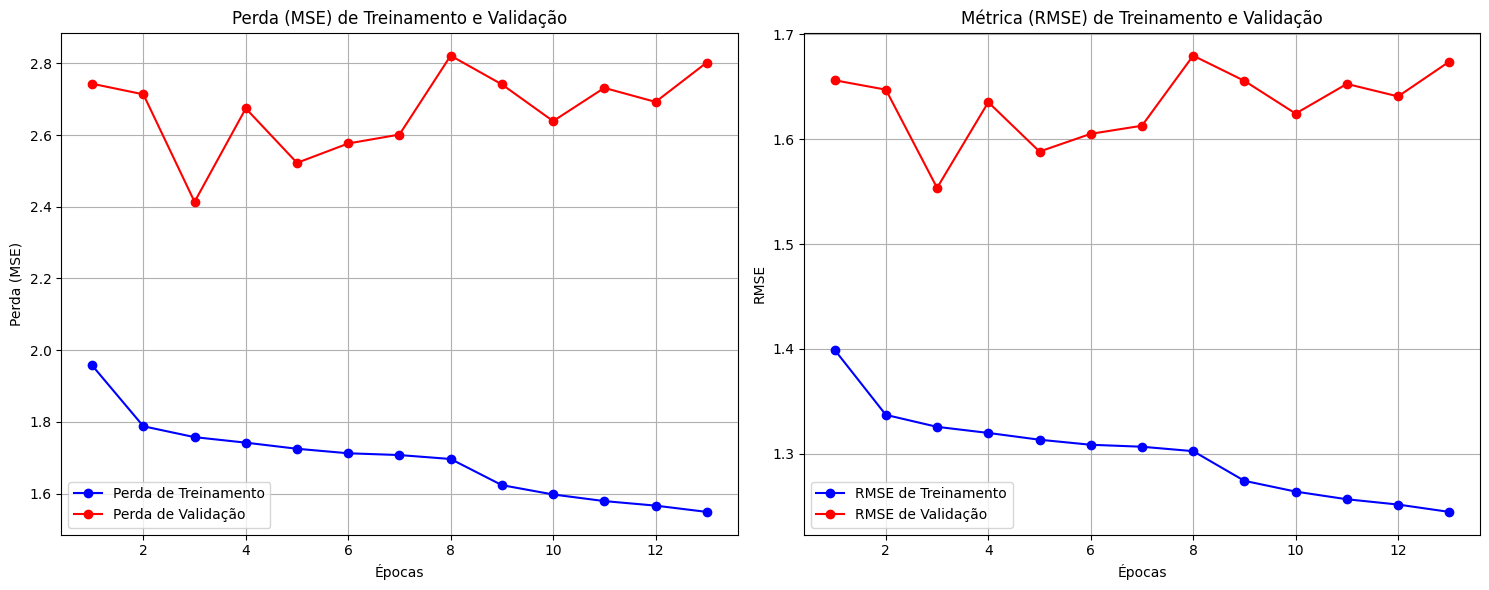

In [11]:
plot_training_history(history)

In [13]:
config['BASE_PATH'] = './nfl-big-data-bowl-2026-prediction/'
predict_and_format_submission(config)


Iniciando pipeline de inferência...


Iniciando pré-processamento robusto...
Pré-processamento robusto concluído.
Prevendo sequência 100/1758...
Prevendo sequência 200/1758...
Prevendo sequência 300/1758...
Prevendo sequência 400/1758...
Prevendo sequência 500/1758...
Prevendo sequência 600/1758...
Prevendo sequência 700/1758...
Prevendo sequência 800/1758...
Prevendo sequência 900/1758...
Prevendo sequência 1000/1758...
Prevendo sequência 1100/1758...
Prevendo sequência 1200/1758...
Prevendo sequência 1300/1758...
Prevendo sequência 1400/1758...
Prevendo sequência 1500/1758...
Prevendo sequência 1600/1758...
Prevendo sequência 1700/1758...
Iniciando a reconstrução das trajetórias e formatação da submissão...

Arquivo 'submission.csv' gerado com sucesso com 20183 linhas.


In [16]:
import pandas as pd
pd.read_csv('submission.csv').iloc[[0, 857, 34, 392, 64]].head()

,id,x,y
0,2024120805_74_52518_1,30.108411,38.765625
857,2024120805_453_55097_29,28.100935,42.241036
34,2024120805_74_54586_2,34.147651,16.090373
392,2024120805_388_55100_5,108.324614,13.941487
64,2024120805_74_53472_10,36.789972,12.148424
